In [11]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple
import os

# %matplotlib widget

In [12]:
# DATA PROCESSING FUNCTIONS

def merge_segments(test_path):   
    # find all dataset segments 
    test_dir_items = os.listdir(test_path)
    segments = []
    for fname in test_dir_items:
        if "segment" in fname:
            segments.append(fname)
        # check if file already exists
        if "merged" in fname:
            print("Merged file already exists!")
            return
    # sort in order of segment number
    segments.sort(key=lambda x: int(x.replace(".", "_").split("_")[1]))  # segment_xxxx.npy  
    print("Segments: ", segments)
    # load data from each segment
    segments_np = []
    for i, segment_fname in enumerate(segments):
        segment = np.load(os.path.join(test_path, segment_fname))
        segments_np.append(segment)
    # merge all segments and save as a single file
    merged_segments = np.concatenate(segments_np, axis=0)
    print("Merged segments shape: ", merged_segments.shape)
    merged_segments_fname = os.path.join(test_path, f"merged.npy")
    np.save(merged_segments_fname, merged_segments)
    print("Saved!")

def load_data(data_path, key_path):
    data = np.load(data_path, allow_pickle=True)
    key = np.load(key_path, allow_pickle=True).item()
    print("Loaded data and key.")
    print("Data shape: ", data.shape)
    print("Key length: ", len(key))
    return data, key

def get_valid_data(data, key):
    # filter dataset based on data_valid flag
    valid_data = data[data[:, key["data_valid"]] == 1]
    print("Valid data shape: ", valid_data.shape)
    return valid_data

# tare force sensor measurements
# filter force sensor data (using med filt)
def tare_and_filter_ati_force_data(data, key, tare_horizon=10, filter_kernel_size=25):
    output_data = data.copy()
    # use N=tare_horizon samples to calculate offsets
    Fx_offset = -np.mean(data[:tare_horizon, key["Fx"]], axis=0)
    Fy_offset = -np.mean(data[:tare_horizon, key["Fy"]], axis=0)
    Fz_offset = -np.mean(data[:tare_horizon, key["Fz"]], axis=0)
    print("ATI sensor offsets:", Fx_offset, Fy_offset, Fz_offset)
    # apply offsets to force data
    output_data[:, key["Fx"]] += Fx_offset
    output_data[:, key["Fy"]] += Fy_offset
    output_data[:, key["Fz"]] += Fz_offset
    # apply filter to force data
    filtered_Fx = medfilt(output_data[:, key["Fx"]], kernel_size=filter_kernel_size)
    filtered_Fy = medfilt(output_data[:, key["Fy"]], kernel_size=filter_kernel_size)
    filtered_Fz = medfilt(output_data[:, key["Fz"]], kernel_size=filter_kernel_size)
    output_data[:, key["Fx"]] = filtered_Fx
    output_data[:, key["Fy"]] = filtered_Fy
    output_data[:, key["Fz"]] = filtered_Fz
    return output_data

# find bad mmiba data and interpolate from previous and next good data
def interpolate_bad_mmiba_data(data, key):
    output_data = data.copy()
    # get mmiba sensor keys
    sensor_idxs = []
    for k in list(key.keys()):
        if 's' in k: # TODO: this might break if we add more columns to the dataset
            sensor_idxs.append(key[k])
    # iterate through rows of data, checking if mmiba data is all zeros
    bad_rows = []
    for i, row in enumerate(data):
        if np.all(row[sensor_idxs] == 0):
            bad_rows.append(i)
            if i==0:
                output_data[i, sensor_idxs] = data[i+1, sensor_idxs]
            elif i==data.shape[0]-1:
                output_data[i, sensor_idxs] = data[i-1, sensor_idxs]
            else:
                output_data[i, sensor_idxs] = (data[i-1, sensor_idxs] + data[i+1, sensor_idxs]) / 2.0
    print("Rows with bad mmiba data: ", bad_rows)
    return output_data

# subtract starting time from dataset
def apply_starting_time_offset(data, key):
    output_data = data.copy()
    start_time = data[0, key["time"]]
    print("Time offset: ", start_time)
    output_data[:, key["time"]] -= start_time
    return output_data

# create final dataset (filtered forces, sensor outputs, only for data in contact, etc.)
def process_data(data, key):
    print("Processing data.")
    # get valid data
    valid_data = get_valid_data(data, key)
    # tare and filter force data
    processed_data = tare_and_filter_ati_force_data(valid_data, key)
    # interpolate bad mmiba data
    processed_data = interpolate_bad_mmiba_data(processed_data, key)
    # apply starting time offset
    processed_data = apply_starting_time_offset(processed_data, key)
    print("Done!")
    return processed_data

# save final dataset
def save_processed_data(processed_data, test_path):
    test_dir_items = os.listdir(test_path)
    for fname in test_dir_items:
        # check if file already exists
        if "processed" in fname:
            print("Processed file already exists!")
            return
    saved_data_fname = os.path.join(test_path, f"processed.npy")
    np.save(saved_data_fname, processed_data)
    print("Saved data!")

In [13]:
# DATA PLOTTING FUNCTIONS

# plot force, position, and raw sensor data
def plot_initial_data(processed_data_path, key_path):
    plot_data, plot_key = load_data(processed_data_path, key_path)

    # plot force data over time
    force_fig, force_ax = plt.subplots(1,1)
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fx"]], label="Fx")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fy"]], label="Fy")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fz"]], label="Fz")
    force_ax.set_title("Force")
    force_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot x,y,z location over time
    loc_fig, loc_ax = plt.subplots(1,1)
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["x_act"]], label="x")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["y1_act"]], label="y")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["z_act"]], label="z")
    loc_ax.set_title("Location")
    loc_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot all sensor data over time
    sensor_fig, sensor_ax = plt.subplots(3,12, figsize=(80,20))
    sensor_keys = []
    for k in list(plot_key.keys()):
        if 's' in k: # TODO: this might break if we add more columns to the dataset
            sensor_keys.append(k)
    k = 0
    for i in range(3):
        for j in range(12):
            cur_key = sensor_keys[k]
            sensor_ax[i,j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key)
            sensor_ax[i,j].set_title(cur_key)
            sensor_ax[i,j].set_ylim(-35000, 35000)
            k += 1
    plt.show()

def plot_single_sensor_data(input_data, input_key, sensor_to_plot):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(input_data[:, input_key["time"]], input_data[:, input_key["Fz"]], label="Fz")
    ax[0].set_title("Fz")
    ax[1].plot(input_data[:, input_key["time"]], input_data[:, input_key["z_act"]], label="z")
    ax[1].set_title("z")
    ax[2].plot(input_data[:, input_key["time"]], input_data[:, input_key[sensor_to_plot]], label=sensor_to_plot)
    ax[2].set_title(sensor_to_plot)
    plt.tight_layout()
    plt.show()

Merged file already exists!
Loaded data and key.
Data shape:  (12169, 51)
Key length:  51
Processing data.
Valid data shape:  (12098, 51)
ATI sensor offsets: 0.03277000000000001 0.05340840000000001 -0.020929299999999998
Rows with bad mmiba data:  []
Time offset:  2460.44458
Done!
Processed file already exists!
Loaded data and key.
Data shape:  (12098, 51)
Key length:  51


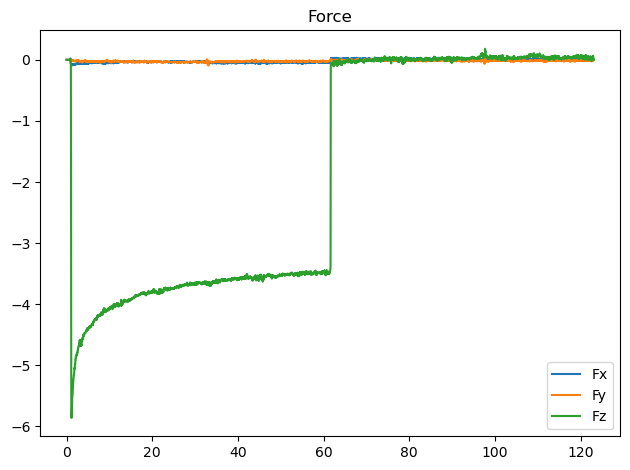

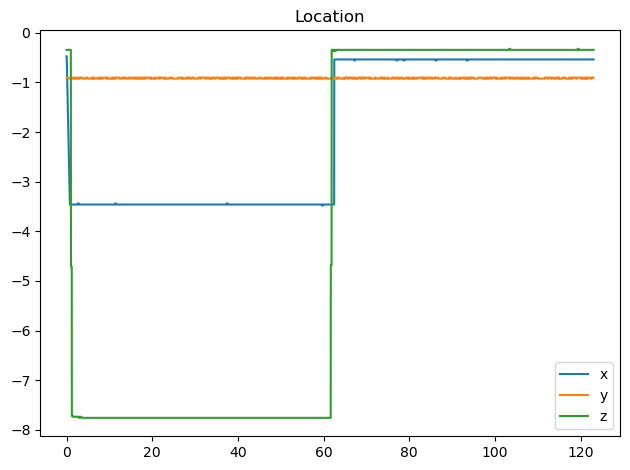

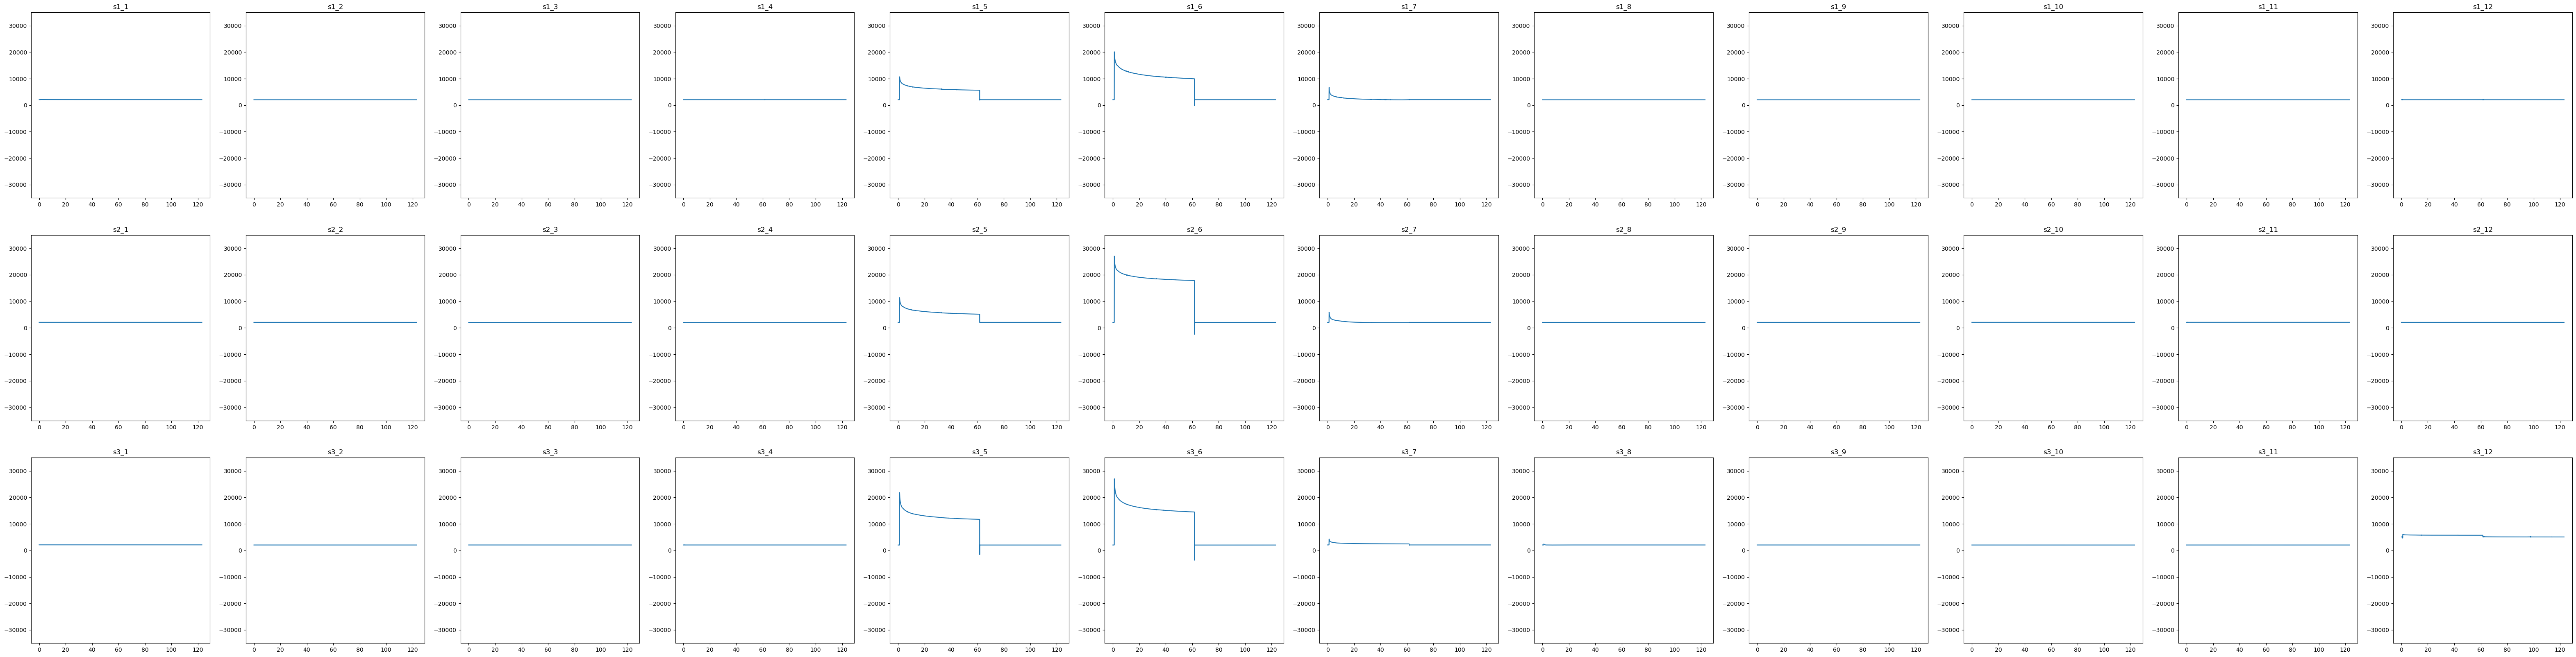

In [17]:
test_path = "raw_data/2024-11-15_14-45-37.807944_SINGLEPRESS_BP_COMBO"

merge_segments(test_path)

raw_data_path = os.path.join(test_path, "merged.npy") 
key_path = os.path.join(test_path, "key.npy")

raw_data, key = load_data(raw_data_path, key_path)
processed_data = process_data(raw_data, key)
save_processed_data(processed_data, test_path)

processed_data_path = os.path.join(test_path, "processed.npy")
processed_data_key_path = os.path.join(test_path, "key.npy")

plot_initial_data(processed_data_path, processed_data_key_path)

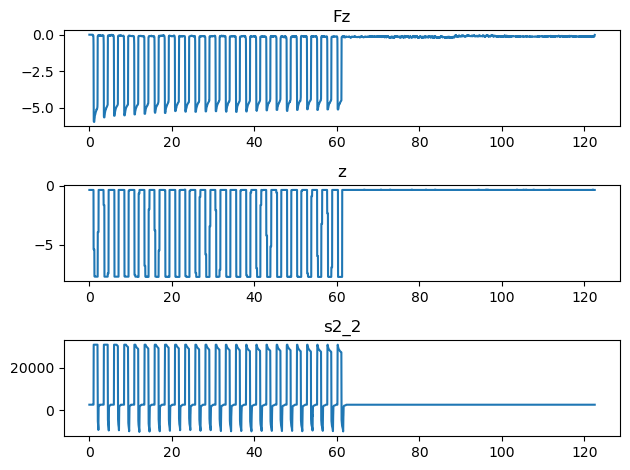

In [186]:
# subplots for fz, z position, and a specific sensor
sensor_to_plot = "s2_2"
plot_single_sensor_data(processed_data, key, sensor_to_plot)

# Testing notes
- Tests all with combo rubber, non-modified ecoflex layer, air channels in middle support piece, plastic frame with full-length legs
- remaining physical variables to test: all ecoflex rubber, less tacky ecoflex layer, no air channels in middle support piece,
- remaining trajectory/dataset variables to test: larger dense grid, sensor readings vs max penetration depth, 

Loaded data and key.
Data shape:  (6044, 47)
Key length:  47
Loaded data and key.
Data shape:  (12044, 47)
Key length:  47


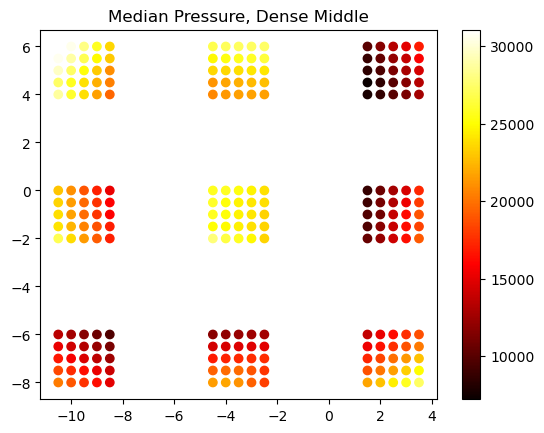

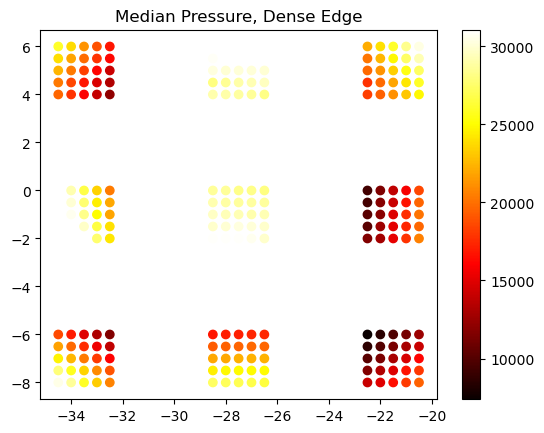

In [248]:
# DATA PATH 1: "raw_data/2024-11-14_21-55-45.193393_DENSE_COMBO"
# DATA PATH 2: "raw_data/2024-11-14_22-16-59.080947_DENSEEDGE_COMBO"
# densely sampled the middle and the edge, in a 2mm x 2mm grid around a center sensor
# 3x3 subplots for sensor data around densely sampled sensor
# filter data based on z-force or z-position, getting just points in contact
# plot max or mean pressure per contact as an image, centered around middle sensor, for middle sensor
# for other sensors, plot max or mean pressure centered around that sensor? or around middle sensor, with value sensor highlighted?

dense_middle_data_path = "raw_data/2024-11-14_21-55-45.193393_DENSE_COMBO/processed.npy"
dense_middle_key_path = "raw_data/2024-11-14_21-55-45.193393_DENSE_COMBO/key.npy"

dense_edge_data_path = "raw_data/2024-11-14_22-16-59.080947_DENSEEDGE_COMBO/processed.npy"
dense_edge_key_path = "raw_data/2024-11-14_22-16-59.080947_DENSEEDGE_COMBO/key.npy"

dense_middle_data, dense_middle_key = load_data(dense_middle_data_path, dense_middle_key_path)
dense_edge_data, dense_edge_key = load_data(dense_edge_data_path, dense_edge_key_path)

# plot dense middle data first
contact_middle_data = dense_middle_data[(dense_middle_data[:, dense_middle_key["z_act"]] < -7.0) & (dense_middle_data[:, dense_middle_key["Fz"]] < -4.0)]
# sensor_to_plot = "s3_5"
# fig, ax = plt.subplots(5,1, figsize=(10,5))
# ax[0].scatter(contact_middle_data[:, dense_middle_key["time"]], contact_middle_data[:, dense_middle_key["Fz"]], label="Fz")
# ax[0].set_title("Fz")
# ax[1].scatter(contact_middle_data[:, dense_middle_key["time"]], contact_middle_data[:, dense_middle_key[sensor_to_plot]], label=sensor_to_plot)
# ax[1].set_title(sensor_to_plot)
# ax[2].scatter(contact_middle_data[:, dense_middle_key["time"]], contact_middle_data[:, dense_middle_key["x_act"]], label="x")
# ax[2].set_title("x")
# ax[3].scatter(contact_middle_data[:, dense_middle_key["time"]], contact_middle_data[:, dense_middle_key["y1_act"]], label="y")
# ax[3].set_title("y")
# ax[4].scatter(contact_middle_data[:, dense_middle_key["time"]], contact_middle_data[:, dense_middle_key["z_act"]], label="z")
# ax[4].set_title("z")
# plt.tight_layout()
# plt.show()
# get matrix of max and mean pressure values for each of the peaks in contact data at each x,y location, for all nine sensors
sensors_to_plot = ["s1_5", "s1_6", "s1_7", "s2_5", "s2_6", "s2_7", "s3_5", "s3_6", "s3_7"]
sensor_offsets = [(-6,-6), (0,-6), (6,-6), (-6,0), (0,0), (6,0), (-6,6), (0,6), (6,6)]
max_pressure_pts = np.zeros((25,9,3))
median_pressure_pts = np.zeros((25,9,3))
# note: y goes from -2 to 0, x goes from -4.5 to -2.5
k = 0
for i in range(5):
    for j in range(5):
        x = -4.5 + j*0.5
        y = 0.0 - i*0.5
        loc_thresh = 0.2
        contact_data_slice = contact_middle_data[(contact_middle_data[:, dense_middle_key["x_act"]] > x-loc_thresh) & (contact_middle_data[:, dense_middle_key["x_act"]] < x+loc_thresh) \
                                                 & (contact_middle_data[:, dense_middle_key["y1_act"]] > y-loc_thresh) & (contact_middle_data[:, dense_middle_key["y1_act"]] < y+loc_thresh)]
       
        for s, sensor_to_plot in enumerate(sensors_to_plot):
            max_pressure_pts[k,s,:] = np.array([x, y, np.max(contact_data_slice[:, dense_middle_key[sensor_to_plot]])])
            median_pressure_pts[k,s,:] = np.array([x, y, np.median(contact_data_slice[:, dense_middle_key[sensor_to_plot]])])

        k+=1

# scatter plot matrix with color scale
full_max_pressure_pts = np.zeros((25*9,3))
full_median_pressure_pts = np.zeros((25*9,3))
for s, sensor_to_plot in enumerate(sensors_to_plot):
    # print(sensor_to_plot, sensor_offsets[s])
    full_max_pressure_pts[(s*25):((s+1)*25),:] = max_pressure_pts[0:25,s,:] + np.array([sensor_offsets[s][0], sensor_offsets[s][1], 0])
    full_median_pressure_pts[(s*25):((s+1)*25),:] = median_pressure_pts[0:25,s,:] + np.array([sensor_offsets[s][0], sensor_offsets[s][1], 0])

fig, ax = plt.subplots(1,1)
# cax0 = ax[0].scatter(full_max_pressure_pts[:,0], full_max_pressure_pts[:,1], c=full_max_pressure_pts[:,2], cmap='hot')
cax1 = ax.scatter(full_median_pressure_pts[:,0], full_median_pressure_pts[:,1], c=full_median_pressure_pts[:,2], cmap='hot')
cbar = fig.colorbar(cax1, ax=ax)
ax.set_title("Median Pressure, Dense Middle")
plt.show()



# then plot dense edge data
contact_edge_data = dense_edge_data[(dense_edge_data[:, dense_edge_key["z_act"]] < -7.0) & (dense_edge_data[:, dense_edge_key["Fz"]] < -4.0)]
# sensor_to_plot = "s2_2"
# fig, ax = plt.subplots(5,1, figsize=(10,5))
# ax[0].scatter(contact_edge_data[:, dense_edge_key["time"]], contact_edge_data[:, dense_edge_key["Fz"]], label="Fz")
# ax[0].set_title("Fz")
# ax[1].scatter(contact_edge_data[:, dense_edge_key["time"]], contact_edge_data[:, dense_edge_key[sensor_to_plot]], label=sensor_to_plot)
# ax[1].set_title(sensor_to_plot)
# ax[2].scatter(contact_edge_data[:, dense_edge_key["time"]], contact_edge_data[:, dense_edge_key["x_act"]], label="x")
# ax[2].set_title("x")
# ax[3].scatter(contact_edge_data[:, dense_edge_key["time"]], contact_edge_data[:, dense_edge_key["y1_act"]], label="y")
# ax[3].set_title("y")
# ax[4].scatter(contact_edge_data[:, dense_edge_key["time"]], contact_edge_data[:, dense_edge_key["z_act"]], label="z")
# ax[4].set_title("z")
# plt.tight_layout()
# plt.show()

# get matrix of max and mean pressure values for each of the peaks in contact data at each x,y location, for all nine sensors
sensors_to_plot = ["s1_1", "s1_2", "s1_3", "s2_1", "s2_2", "s2_3", "s3_1", "s3_2", "s3_3"]
sensor_offsets = [(-6,-6), (0,-6), (6,-6), (-6,0), (0,0), (6,0), (-6,6), (0,6), (6,6)]
max_pressure_pts = np.zeros((25,9,3))
median_pressure_pts = np.zeros((25,9,3))
# note: y goes from -2 to 0, x goes from -28.5 to -26.5
k = 0
for i in range(5):
    for j in range(5):
        x = -28.5 + j*0.5
        y = 0.0 - i*0.5
        loc_thresh = 0.2
        contact_data_slice = contact_edge_data[(contact_edge_data[:, dense_edge_key["x_act"]] > x-loc_thresh) & (contact_edge_data[:, dense_edge_key["x_act"]] < x+loc_thresh) \
                                                 & (contact_edge_data[:, dense_edge_key["y1_act"]] > y-loc_thresh) & (contact_edge_data[:, dense_edge_key["y1_act"]] < y+loc_thresh)]
       
        for s, sensor_to_plot in enumerate(sensors_to_plot):
            max_pressure_pts[k,s,:] = np.array([x, y, np.max(contact_data_slice[:, dense_edge_key[sensor_to_plot]])])
            median_pressure_pts[k,s,:] = np.array([x, y, np.median(contact_data_slice[:, dense_edge_key[sensor_to_plot]])])

        k+=1

# scatter plot matrix with color scale
full_max_pressure_pts = np.zeros((25*9,3))
full_median_pressure_pts = np.zeros((25*9,3))
for s, sensor_to_plot in enumerate(sensors_to_plot):
    # print(sensor_to_plot, sensor_offsets[s])
    full_max_pressure_pts[(s*25):((s+1)*25),:] = max_pressure_pts[0:25,s,:] + np.array([sensor_offsets[s][0], sensor_offsets[s][1], 0])
    full_median_pressure_pts[(s*25):((s+1)*25),:] = median_pressure_pts[0:25,s,:] + np.array([sensor_offsets[s][0], sensor_offsets[s][1], 0])

fig, ax = plt.subplots(1,1)
# cax0 = ax[0].scatter(full_max_pressure_pts[:,0], full_max_pressure_pts[:,1], c=full_max_pressure_pts[:,2], cmap='hot')
cax1 = ax.scatter(full_median_pressure_pts[:,0], full_median_pressure_pts[:,1], c=full_median_pressure_pts[:,2], cmap='hot')
cbar = fig.colorbar(cax1, ax=ax)
ax.set_title("Median Pressure, Dense Edge")
plt.show()

Loaded data and key.
Data shape:  (8725, 47)
Key length:  47


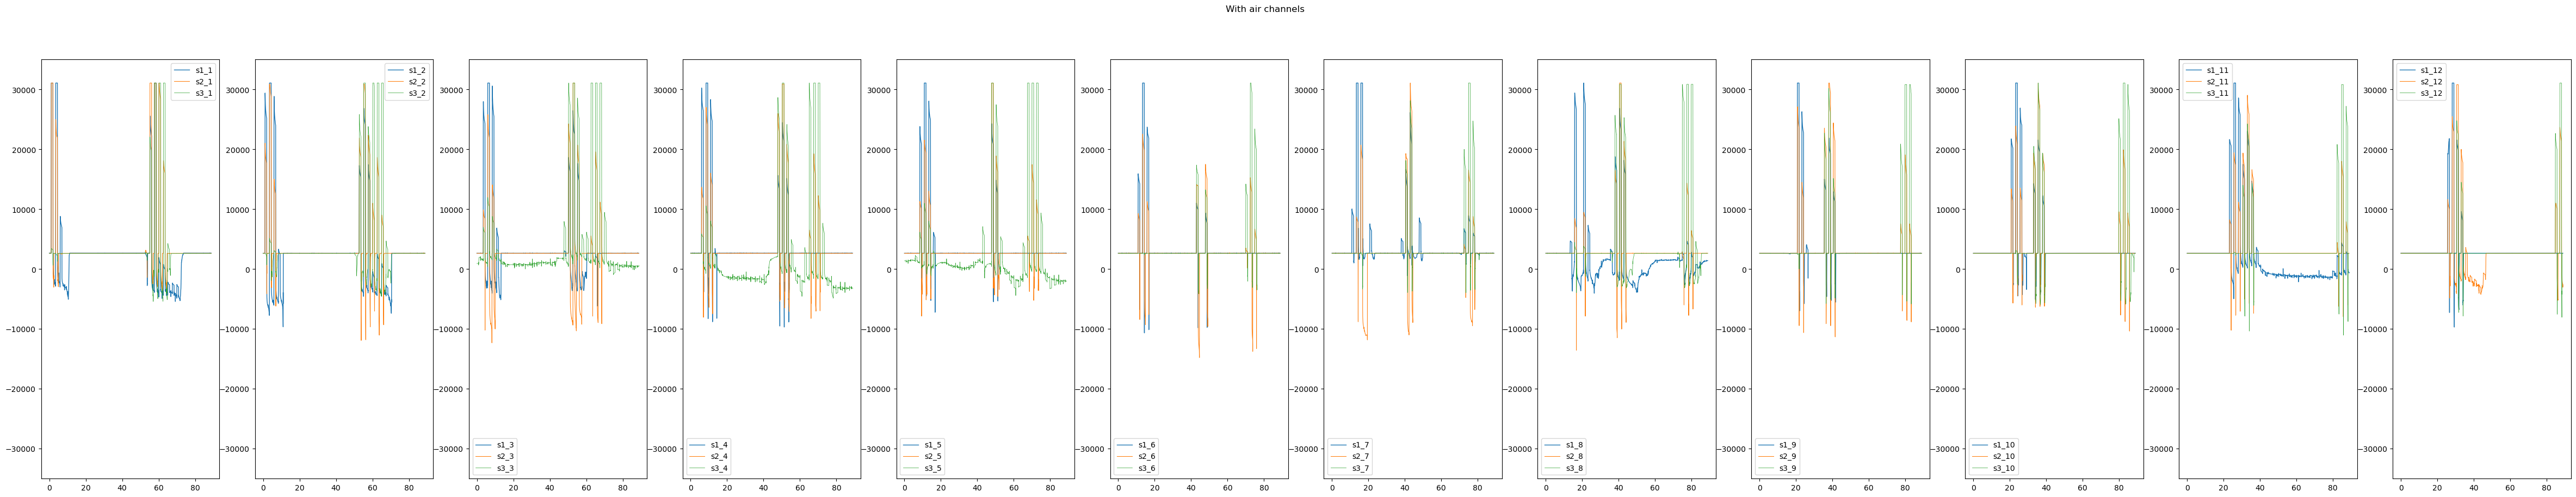

Loaded data and key.
Data shape:  (8728, 51)
Key length:  51


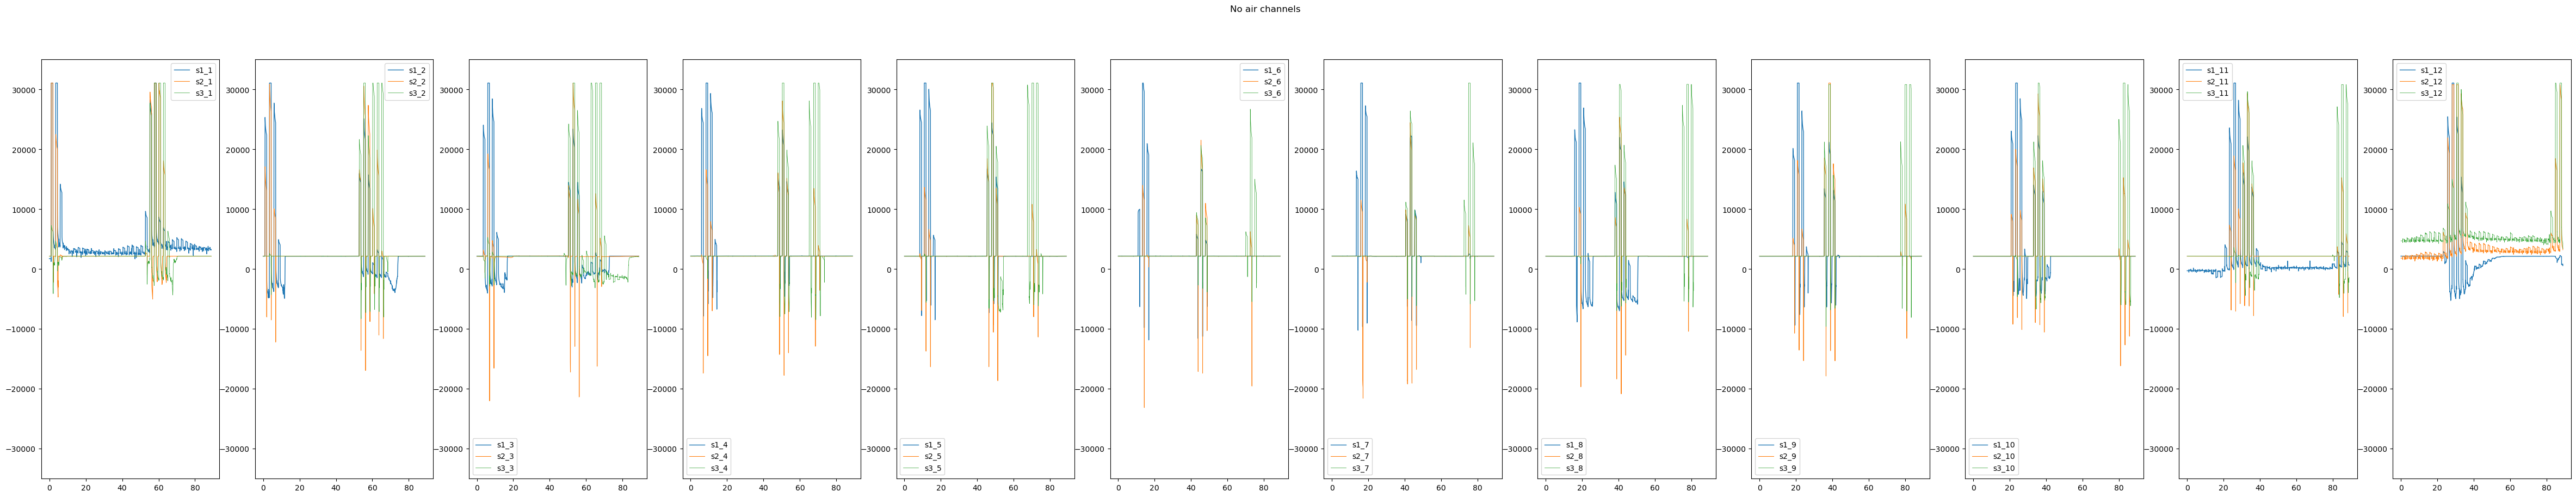

In [5]:
# DATA PATH: "raw_data/2024-11-14_21-51-49.622964_FULLGRID_COMBO"
# sampled almost directly above each individual sensor
# for full grid, trim contact data for each point, then plot max or mean pressure as an image of all sensors?
# could also overlay the spread of sensor responses, should all be similar?
# could plot different types (edge, corner, center), make some conclusions based on sensor responses?


grid_w_ac_data = "raw_data/2024-11-14_21-51-49.622964_FULLGRID_COMBO/processed.npy"
grid_w_ac_key = "raw_data/2024-11-14_21-51-49.622964_FULLGRID_COMBO/key.npy"

plot_data, plot_key = load_data(grid_w_ac_data, grid_w_ac_key)

# plot all sensor data over time
sensor_fig, sensor_ax = plt.subplots(1,12, figsize=(60,10))
sensor_keys = []
for k in list(plot_key.keys()):
    if 's' in k: # TODO: this might break if we add more columns to the dataset
        sensor_keys.append(k)
k = 0
for i in range(3):
    for j in range(12):
        cur_key = sensor_keys[k]
        sensor_ax[j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key, linewidth=1.0-0.25*i)
        # sensor_ax[j].set_title(cur_key)
        
        k += 1
for j in range(12):
    sensor_ax[j].legend()
    sensor_ax[j].set_ylim(-35000, 35000)
plt.suptitle("With air channels")
plt.show()

grid_no_ac_data = "raw_data/2024-11-15_13-00-49.522016_FULLGRID_COMBO/processed.npy"
grid_no_ac_key = "raw_data/2024-11-15_13-00-49.522016_FULLGRID_COMBO/key.npy"

plot_data, plot_key = load_data(grid_no_ac_data, grid_no_ac_key)

# plot all sensor data over time
sensor_fig, sensor_ax = plt.subplots(1,12, figsize=(60,10))
sensor_keys = []
for k in list(plot_key.keys()):
    if 's' in k: # TODO: this might break if we add more columns to the dataset
        sensor_keys.append(k)
k = 0
for i in range(3):
    for j in range(12):
        cur_key = sensor_keys[k]
        sensor_ax[j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key, linewidth=1.0-0.25*i)
        # sensor_ax[j].set_title(cur_key)
        
        k += 1
for j in range(12):
    sensor_ax[j].legend()
    sensor_ax[j].set_ylim(-35000, 35000)
plt.suptitle("No air channels")
plt.show()




In [ ]:


# DATA_PATH: "raw_data/2024-11-14_22-06-06.178108_SINGLEPRESS_COMBO"
# pressed a single sensor for 60 seconds, then released for 60 seconds
# plot time response of Fz and sensor reading
# fit time constant?
# plot time responses of neighboring sensors in cardinal directions? plot in 3x3 subplot grid?






